In [1]:
import random
import networkx as nx
import plotly as plt
import plotly.graph_objects as go
import pandas as pd
import io
import base64
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def initial_state(G):
    state = {node: 'S' for node in G.nodes}
    patient_zero_1 = random.choice(list(G.nodes))
    state[patient_zero_1] = 'I'
    return state

In [3]:
def state_transition_SIRV(G, current_state):
    
    ALPHA = 0.1
    BETA = 0.1
    GAMMA = 0.1
    PVACC = 0.1
    FEB = 0.1
  
    next_state = {}
    
    for node in G.nodes:
        if current_state[node] == 'I': #Se è infected può passare a ricovered
            if random.random() < BETA:
                next_state[node] = 'R'
        elif current_state[node] == 'R': #Da recovered può tornare ad essere susceptible
            if random.random() < GAMMA:
                next_state[node] = 'S'
        else: #Da susceptible può passare a vaccinated
            if current_state[node] == 'S':
                if random.random() < PVACC:
                    next_state[node] = 'V'
                else: #Oppure in base allo stato dei vicini si può infettare
                    for neighbor in G.neighbors(node):
                        if current_state[neighbor] == 'I' :
                            if random.random() < ALPHA:
                                next_state[node] = 'I'
                                if random.random() < FEB:
                                    fever = True
                            break
    return next_state

In [4]:
def state_transition_SIR(G, current_state):
    
    ALPHA = 0.1
    BETA = 0.1
    GAMMA = 0.1
    
    next_state = {}

    for node in G.nodes:
        if current_state[node] == 'I':  # Se è infetto, può essere ricoverato
            if random.random() < BETA:
                next_state[node] = 'R'
        elif current_state[node] == 'R': #Da recovered può tornare ad essere susceptible
            if random.random() < GAMMA:
                next_state[node] = 'S'
        else:  # Se è suscettibile, può infettarsi
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < ALPHA:
                        next_state[node] = 'I'
                        break  # Un individuo può essere infettato solo una volta nello stesso passo di simulazione

    return next_state

In [5]:
class StopCondition(StopIteration):
    pass

In [6]:
class Simulation:
    def __init__(self, G, initial_state, state_transition, stop_condition=None, name=''):

        self.G = G
        self._initial_state = initial_state
        self._state_transition_function = state_transition #Modificato
        self._stop_condition = stop_condition
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

    def _append_state(self, state):
        self._states.append(state)
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            for n in self.G.nodes():
                nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        
        if self._state_transition_function == state_transition_SIR: #Modificato
            new_state = state_transition_SIR(self.G, state)
        elif self._state_transition_function == state_transition_SIRV:
            new_state = state_transition_SIRV(self.G, state)
        else:
            raise ValueError(f"Invalid state transition function: {self._state_transition_function}")
        
        state.update(new_state)
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        return len(self._states) - 1

    def state(self, step=-1):
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)

    def draw(self, step=-1, labels=None, **kwargs):
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)
        
        plt.show()

        return plt.gca()

    def run(self, steps=1):
        for _ in range(steps):
            try:
                self._step();
            except StopCondition as e:
                print("Stop condition met at step %i." % self.steps);
                break;
        return self

In [7]:
global G

In [8]:
G = nx.complete_graph(10)

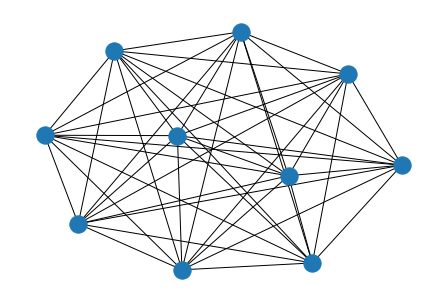

In [9]:
nx.draw(G)

In [10]:
selected_alg_type = 'sir'

In [11]:
if selected_alg_type == 'sir':
    _state_transition_function = state_transition_SIR
elif selected_alg_type == 'sirv':
    _state_transition_function = state_transition_SIRV
else:
    raise ValueError(f"Invalid algorithm type: {selected_alg_type}")

sim1 = Simulation(G, initial_state, _state_transition_function)

In [12]:
simulation_result = sim1.run(10)

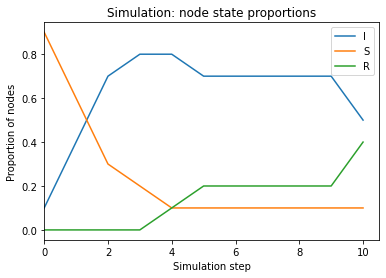

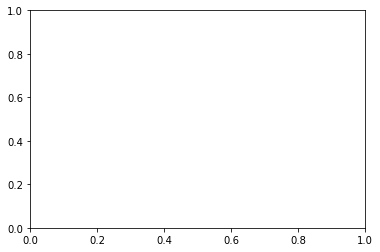

In [13]:
if simulation_result is not None and hasattr(simulation_result, 'plot'):
    simulation_result.plot()
else:
    print("Il risultato della simulazione non è valido o non ha il metodo 'plot()'")